In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.options.mode.chained_assignment = None  # default='warn'

# Input data files are available in the read-only "../data/" directory

import os
import os.path as osp
from tqdm import tqdm
from collections import Counter

ds_name = 'resp'
date = '20230131'
ds_folder = f'/mnt/data2/chaoyue/data/ddf_{ds_name}_{date}'
for dirname, _, filenames in os.walk(ds_folder):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/data2/chaoyue/data/ddf_resp_20230131/split_rs123/valid_edge.csv
/mnt/data2/chaoyue/data/ddf_resp_20230131/split_rs123/test.csv
/mnt/data2/chaoyue/data/ddf_resp_20230131/split_rs123/test_edge.csv
/mnt/data2/chaoyue/data/ddf_resp_20230131/split_rs123/train.csv
/mnt/data2/chaoyue/data/ddf_resp_20230131/split_rs123/train_edge.csv
/mnt/data2/chaoyue/data/ddf_resp_20230131/split_rs123/valid.csv


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import norm
#import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, norm
from sklearn.neighbors import KNeighborsRegressor
from sklearn import preprocessing
%matplotlib inline

# Set it to None to display all columns in the dataframe
pd.set_option('display.max_columns', None)

In [4]:
#Import the files
train_node_df = pd.read_csv(f'{ds_folder}/split_rs123/train.csv')
train_edge_df = pd.read_csv(f'{ds_folder}/split_rs123/train_edge.csv')
valid_node_df = pd.read_csv(f'{ds_folder}/split_rs123/valid.csv')
valid_edge_df = pd.read_csv(f'{ds_folder}/split_rs123/valid_edge.csv')
test_node_df = pd.read_csv(f'{ds_folder}/split_rs123/test.csv')
test_edge_df = pd.read_csv(f'{ds_folder}/split_rs123/test_edge.csv')

In [5]:
train_node_df = pd.concat([train_node_df,valid_node_df], axis=0)
train_edge_df = pd.concat([train_edge_df,valid_edge_df], axis=0)

In [6]:
train_node_df

,index,sim,cluster_id,state,dynamic,node,dynamic_cat
0,0,1000,Background,A,static,1,0
1,1,1000,Background,A,static,2,0
2,2,1000,Background,A,static,4,0
3,3,1000,Background,A,static,817,0
4,4,1000,Background,A,static,1549,0
...,...,...,...,...,...,...,...
6159075,33686209,9993,c5,F,growth,3042,2
6159076,33686210,9993,c5,F,growth,3048,2
6159077,33686211,9993,c5,F,growth,3041,2
6159078,33686212,9993,c5,F,growth,3040,2


In [7]:
train_edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm
0,1000,1916,1917,-1.625870,-1.094222
1,1000,1917,1,-0.323070,-0.671324
2,1000,1917,1918,0.408957,0.052930
3,1000,1918,1919,-0.619706,-0.725592
4,1000,1919,2,-0.323070,-0.614291
...,...,...,...,...,...
6157360,9993,3486,3494,0.266847,-0.224700
6157361,9993,3484,3495,0.103273,-0.243573
6157362,9993,3407,3496,2.414699,7.013381
6157363,9993,3496,180,-1.625870,-1.090092


In [11]:
node_df = pd.concat([train_node_df,test_node_df], axis=0)
edge_df = pd.concat([train_edge_df,test_edge_df], axis=0)

In [12]:
node_df

,index,sim,cluster_id,state,dynamic,node,dynamic_cat
0,0,1000,Background,A,static,1,0
1,1,1000,Background,A,static,2,0
2,2,1000,Background,A,static,4,0
3,3,1000,Background,A,static,817,0
4,4,1000,Background,A,static,1549,0
...,...,...,...,...,...,...,...
6164499,33702496,9998,c6,E,static,3304,0
6164500,33702497,9998,c6,E,static,1150,0
6164501,33702498,9998,c6,E,static,1969,0
6164502,33702499,9998,c6,E,static,1970,0


In [13]:
edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm
0,1000,1916,1917,-1.625870,-1.094222
1,1000,1917,1,-0.323070,-0.671324
2,1000,1917,1918,0.408957,0.052930
3,1000,1918,1919,-0.619706,-0.725592
4,1000,1919,2,-0.323070,-0.614291
...,...,...,...,...,...
6162784,9998,3921,3922,-0.323070,-0.627705
6162785,9998,3922,108,-0.323070,-0.589188
6162786,9998,3922,3923,0.266847,-0.125765
6162787,9998,3923,357,0.534553,0.045834


In [15]:
feat_dict = {'mean': [7.76932811e+00, 6.99253729e-03, 2.39559804e+00, 6.99233009e-03],
             'std': [6.21861096e+00, 5.62641630e-03, 9.31331540e-01, 5.62596674e-03]}

In [16]:
feat_dict

{'mean': [7.76932811, 0.00699253729, 2.39559804, 0.00699233009],
 'std': [6.21861096, 0.0056264163, 0.93133154, 0.00562596674]}

In [18]:
train_edge_df['weight1'] = np.sinh(train_edge_df['weight1_arsinh-norm'].values*feat_dict['std'][2]+feat_dict['mean'][2])
train_edge_df['weight2'] = np.sinh(train_edge_df['weight2_arsinh-norm'].values*feat_dict['std'][3]+feat_dict['mean'][3])

In [19]:
train_edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm,weight1,weight2
0,1000,1916,1917,-1.625870,-1.094222,1.0,0.000836
1,1000,1917,1,-0.323070,-0.671324,4.0,0.003215
2,1000,1917,1918,0.408957,0.052930,8.0,0.007290
3,1000,1918,1919,-0.619706,-0.725592,3.0,0.002910
4,1000,1919,2,-0.323070,-0.614291,4.0,0.003536
...,...,...,...,...,...,...,...
6157360,9993,3486,3494,0.266847,-0.224700,7.0,0.005728
6157361,9993,3484,3495,0.103273,-0.243573,6.0,0.005622
6157362,9993,3407,3496,2.414699,7.013381,52.0,0.046466
6157363,9993,3496,180,-1.625870,-1.090092,1.0,0.000860


In [20]:
test_edge_df['weight1'] = np.sinh(test_edge_df['weight1_arsinh-norm'].values*feat_dict['std'][2]+feat_dict['mean'][2])
test_edge_df['weight2'] = np.sinh(test_edge_df['weight2_arsinh-norm'].values*feat_dict['std'][3]+feat_dict['mean'][3])
edge_df['weight1'] = np.sinh(edge_df['weight1_arsinh-norm'].values*feat_dict['std'][2]+feat_dict['mean'][2])
edge_df['weight2'] = np.sinh(edge_df['weight2_arsinh-norm'].values*feat_dict['std'][3]+feat_dict['mean'][3])

In [21]:
edge_df

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm,weight1,weight2
0,1000,1916,1917,-1.625870,-1.094222,1.0,0.000836
1,1000,1917,1,-0.323070,-0.671324,4.0,0.003215
2,1000,1917,1918,0.408957,0.052930,8.0,0.007290
3,1000,1918,1919,-0.619706,-0.725592,3.0,0.002910
4,1000,1919,2,-0.323070,-0.614291,4.0,0.003536
...,...,...,...,...,...,...,...
6162784,9998,3921,3922,-0.323070,-0.627705,4.0,0.003461
6162785,9998,3922,108,-0.323070,-0.589188,4.0,0.003678
6162786,9998,3922,3923,0.266847,-0.125765,7.0,0.006285
6162787,9998,3923,357,0.534553,0.045834,9.0,0.007250


In [22]:
edge_df.describe()

,sim,new_from,new_to,weight1_arsinh-norm,weight2_arsinh-norm,weight1,weight2
count,3.080149e+07,3.080149e+07,3.080149e+07,3.080149e+07,3.080149e+07,3.080149e+07,3.080149e+07
mean,4.784136e+03,2.732242e+03,1.804311e+03,4.358594e-05,1.956705e-04,7.770679e+00,6.993638e-03
std,2.869161e+03,5.360678e+02,1.050006e+03,1.000141e+00,1.000424e+00,6.221488e+00,5.628800e-03
min,1.000000e+00,1.587000e+03,1.000000e+00,-2.572229e+00,-1.242867e+00,4.043819e-09,1.773339e-12
25%,2.259000e+03,2.286000e+03,8.990000e+02,-6.197058e-01,-7.717689e-01,3.000000e+00,2.650387e-03
50%,4.717000e+03,2.722000e+03,1.797000e+03,1.032734e-01,-2.162957e-01,6.000000e+00,5.775490e-03
75%,7.200000e+03,3.158000e+03,2.696000e+03,7.489322e-01,5.188850e-01,1.100000e+01,9.911722e-03
max,9.998000e+03,4.548000e+03,4.548000e+03,2.954834e+00,1.308911e+01,8.600000e+01,8.071865e-02


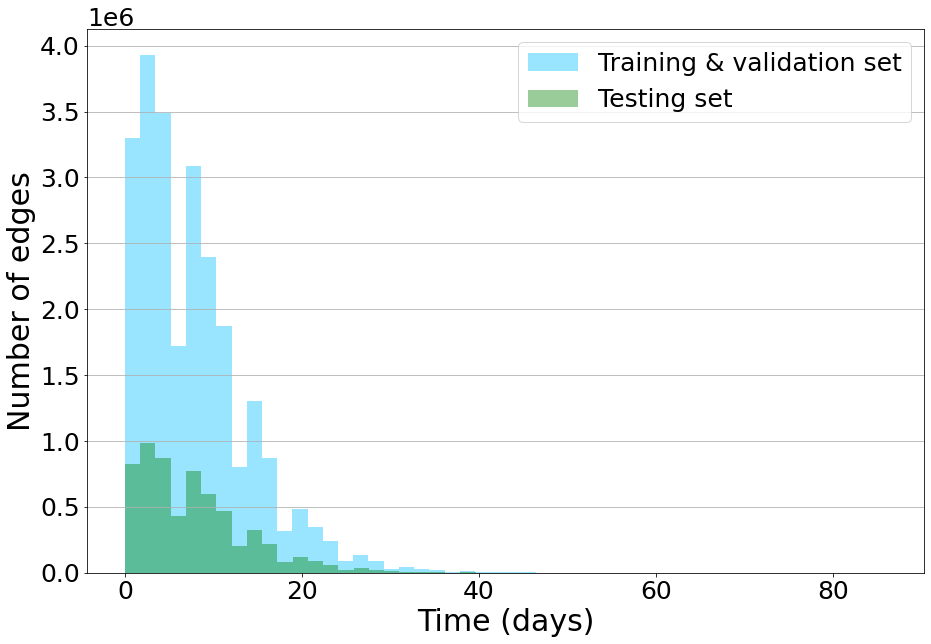

In [28]:
feats = ['weight1', 'weight2', 'weight1_arsinh-norm', 'weight2_arsinh-norm']
feat = feats[0]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_edge_df[feat],bins=47,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,3800000))
ax1.axes.set_ylabel("Number of edges",fontsize=30)
ax1.axes.set_xlabel(f"Time (days)",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

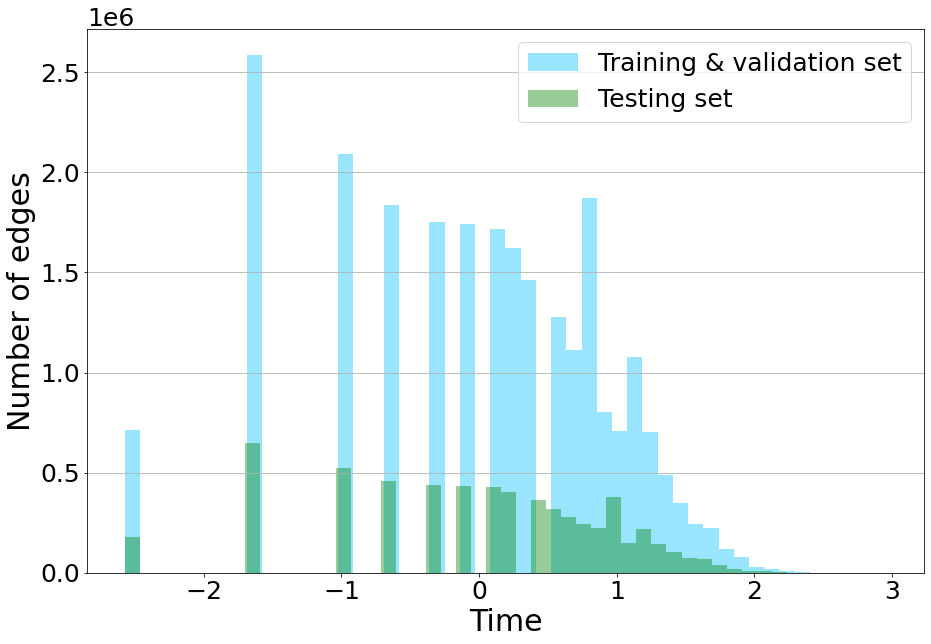

In [54]:
feat = feats[2]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_edge_df[feat],bins=50,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,3800000))
ax1.axes.set_ylabel("Number of edges",fontsize=30)
ax1.axes.set_xlabel(f"Time",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

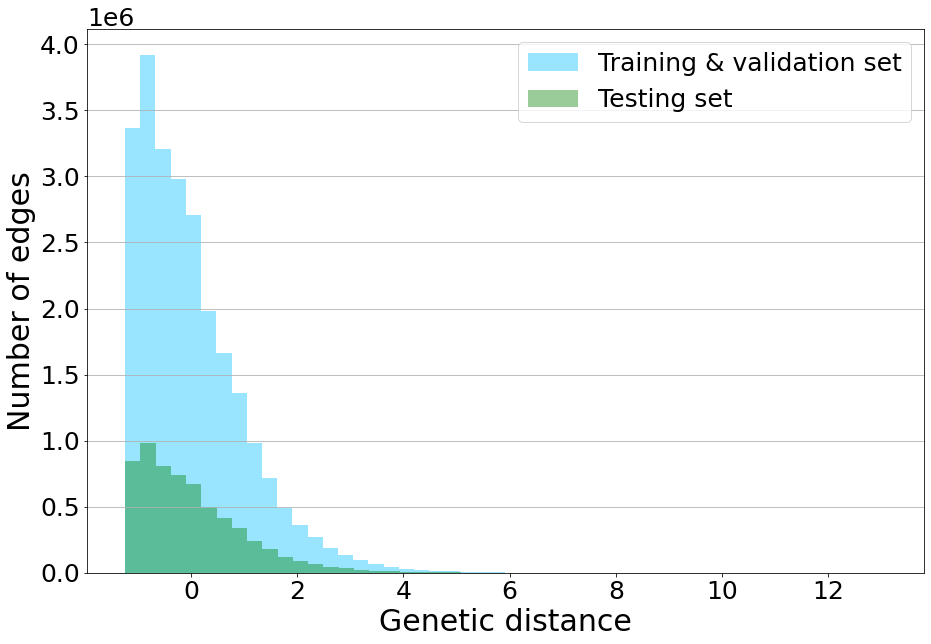

In [55]:
feat = feats[3]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_edge_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_edge_df[feat],bins=45,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,3800000))
ax1.axes.set_ylabel("Number of edges",fontsize=30)
ax1.axes.set_xlabel(f"Genetic distance",fontsize=30)
plt.grid(axis = "y")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

In [56]:
train_ids = train_edge_df['sim'].unique()
test_ids = test_edge_df['sim'].unique()

In [58]:
from collections import defaultdict
train_dist = defaultdict(list)
all_bg = []
for tree_id in train_ids:
    onetree_node_df = train_node_df[train_node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    train_dist['sim'].append(tree_id)
    train_dist['num_nodes'].append(num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        train_dist[f'num_{label}_nodes'].append(num_label_nodes)
        train_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)  
    
train_dist_df = pd.DataFrame.from_dict(train_dist)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:>]], dtype=object)

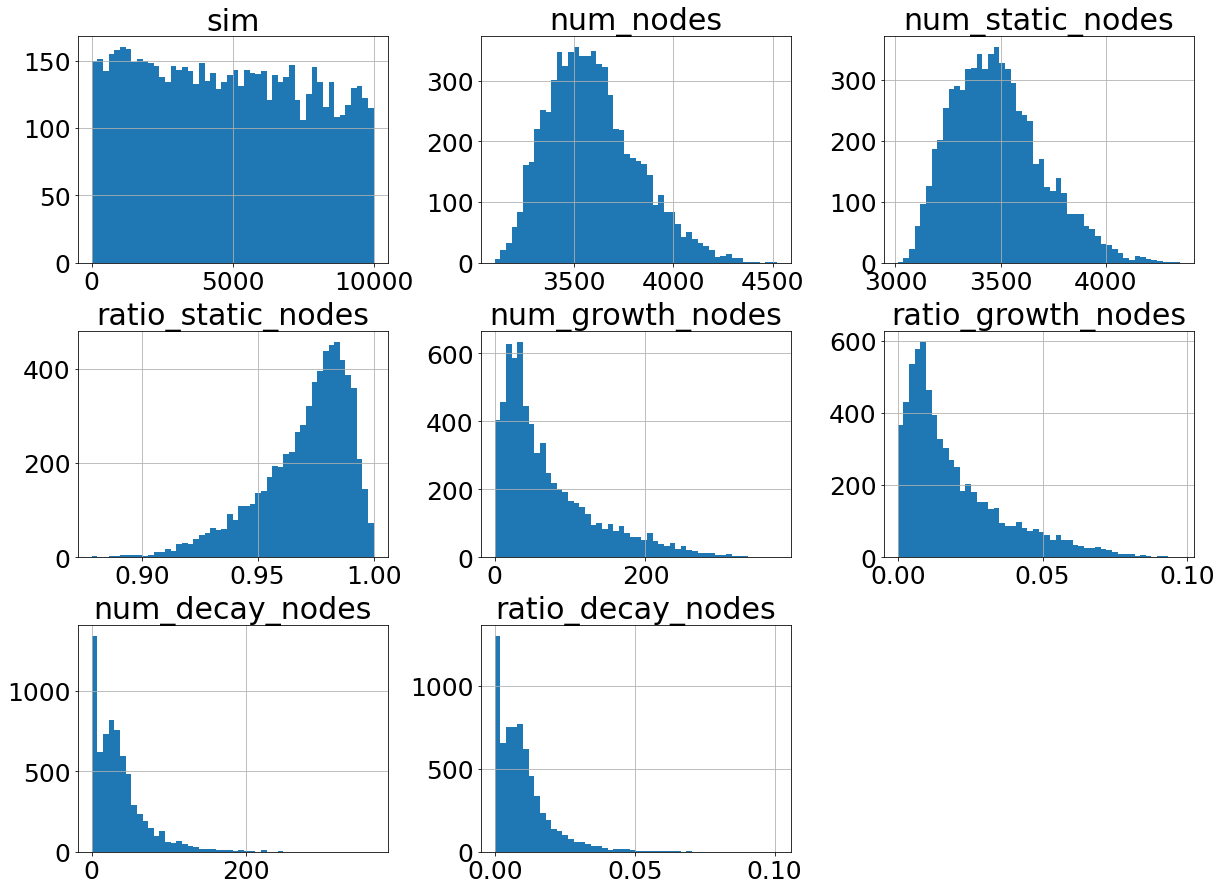

In [59]:
train_dist_df.hist(bins=50,figsize=(20,15))

In [60]:
from collections import defaultdict
test_dist = defaultdict(list)
for tree_id in test_ids:
    test_dist['sim'].append(tree_id)
    onetree_node_df = test_node_df[test_node_df['sim'] == tree_id] 
    num_nodes = onetree_node_df.shape[0]
    test_dist['num_nodes'].append(num_nodes)
    
    for label in ['static', 'growth', 'decay']:
        num_label_nodes = onetree_node_df[onetree_node_df['dynamic']==label].shape[0]
        test_dist[f'num_{label}_nodes'].append(num_label_nodes)
        test_dist[f'ratio_{label}_nodes'].append(num_label_nodes / num_nodes)
    
test_dist_df = pd.DataFrame.from_dict(test_dist)

array([[<AxesSubplot:title={'center':'sim'}>,
        <AxesSubplot:title={'center':'num_nodes'}>,
        <AxesSubplot:title={'center':'num_static_nodes'}>],
       [<AxesSubplot:title={'center':'ratio_static_nodes'}>,
        <AxesSubplot:title={'center':'num_growth_nodes'}>,
        <AxesSubplot:title={'center':'ratio_growth_nodes'}>],
       [<AxesSubplot:title={'center':'num_decay_nodes'}>,
        <AxesSubplot:title={'center':'ratio_decay_nodes'}>,
        <AxesSubplot:>]], dtype=object)

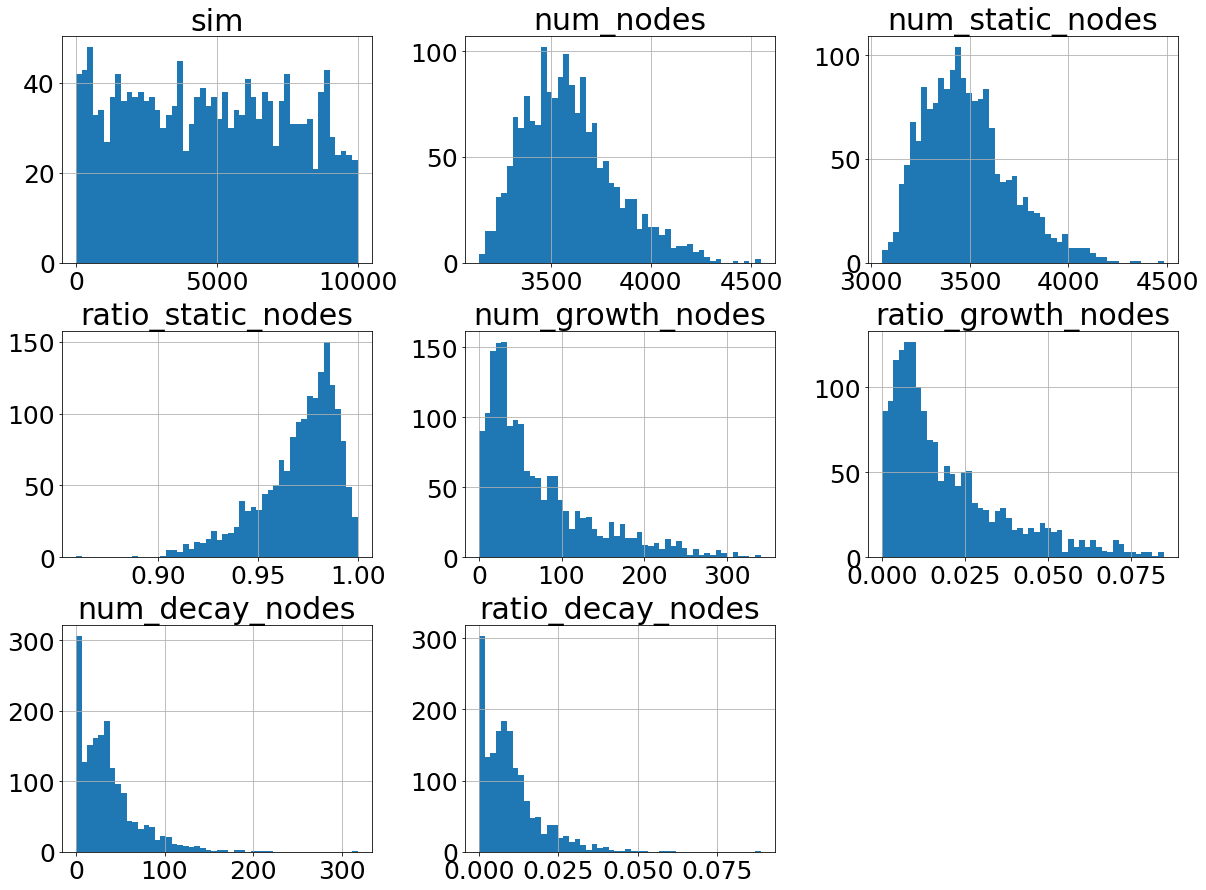

In [61]:
test_dist_df.hist(bins=50,figsize=(20,15))

In [66]:
test_dist_df.columns.values[1:]

array(['num_nodes', 'num_static_nodes', 'ratio_static_nodes',
       'num_growth_nodes', 'ratio_growth_nodes', 'num_decay_nodes',
       'ratio_decay_nodes'], dtype=object)

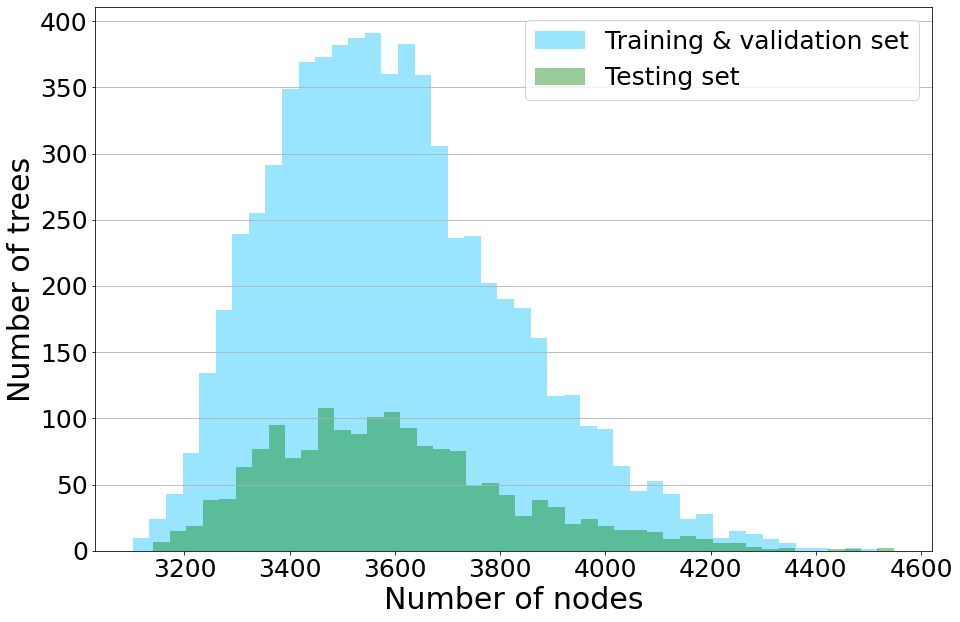

In [72]:
i = 0
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=45,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

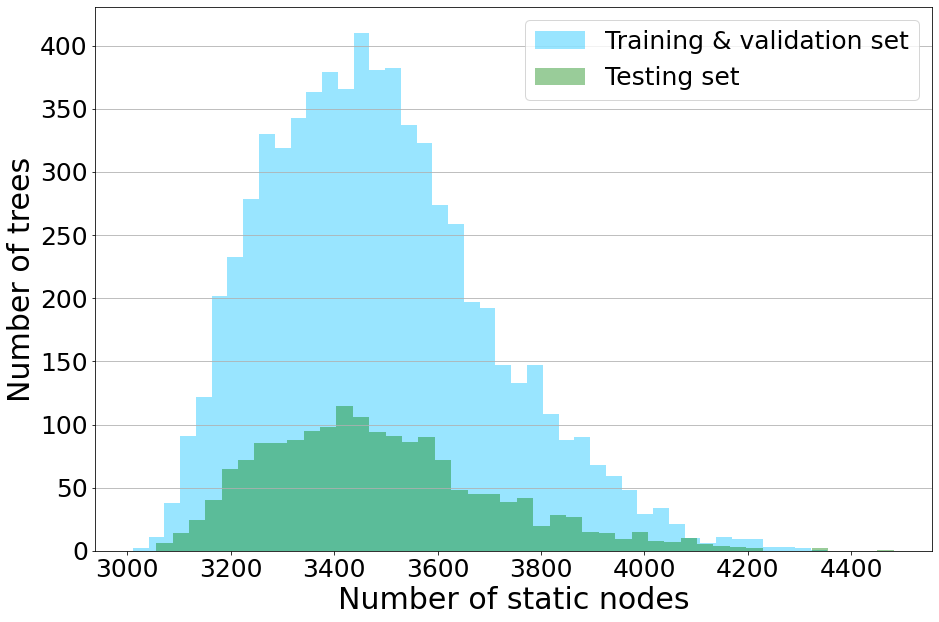

In [90]:
i = 1
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=45,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of static nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

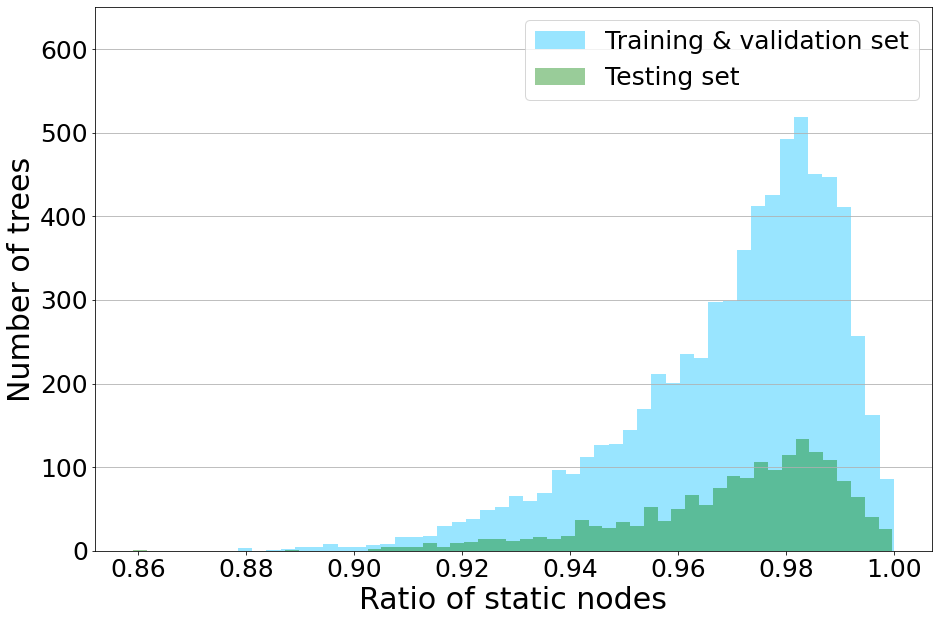

In [96]:
i = 2
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=55,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
ax1.set(ylim=(0,650))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Ratio of static nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

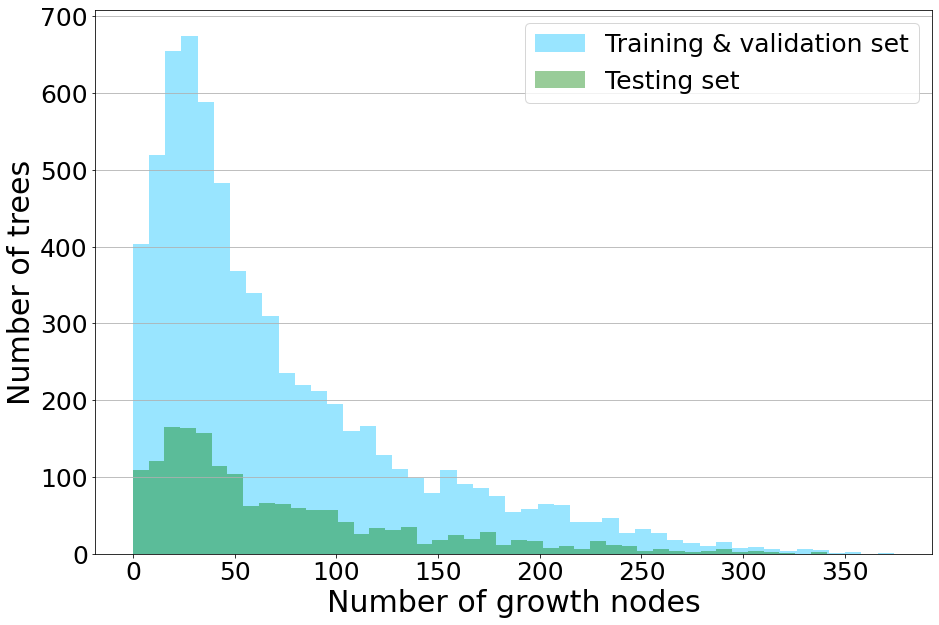

In [101]:
i = 3
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=44,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of growth nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

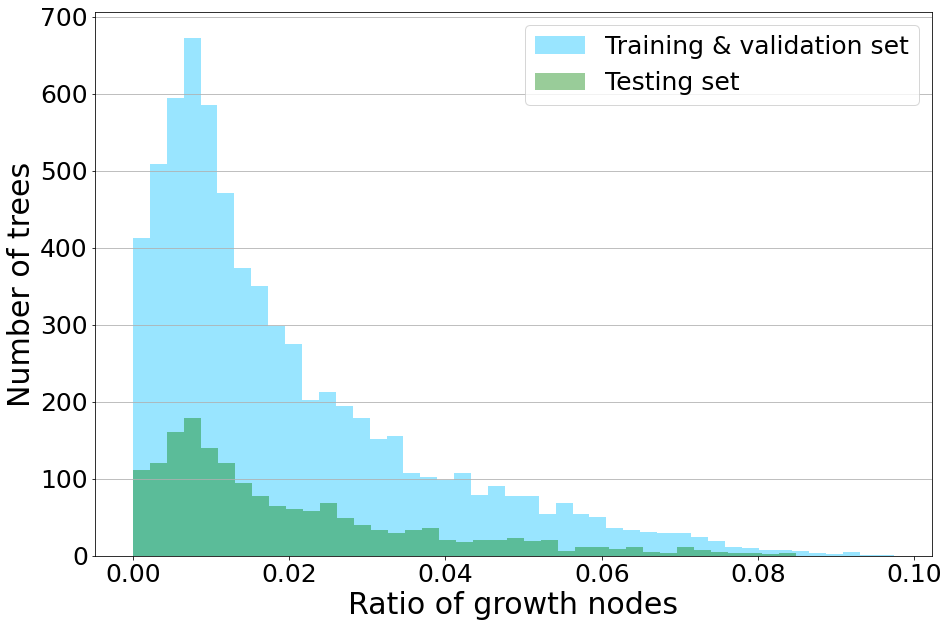

In [106]:
i = 4
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=39,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Ratio of growth nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

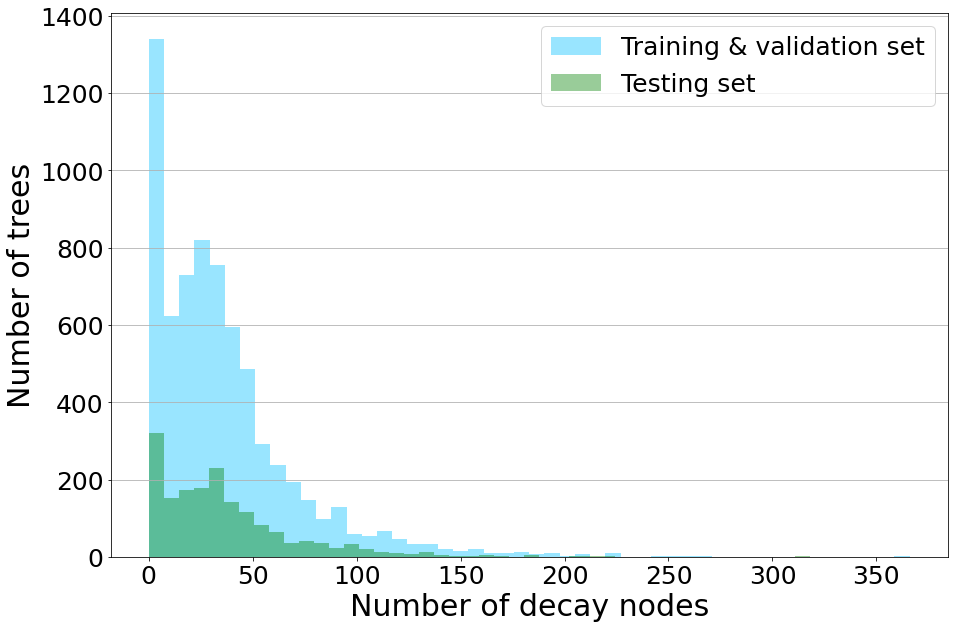

In [111]:
i = 5
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=44,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Number of decay nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')

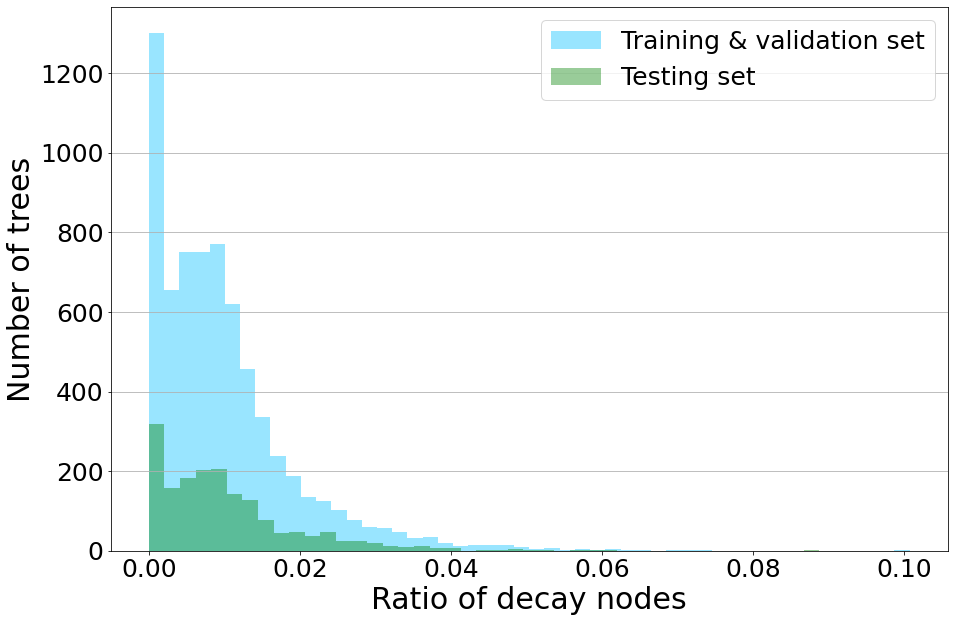

In [115]:
i = 6
feat = test_dist_df.columns.values[1:][i]
fig = plt.figure(figsize=[15,10])
plt.rcParams.update({'font.size': 25})
ax1 = fig.add_subplot(111)
#ax2 = ax1.twinx()
sns.distplot(train_dist_df[feat],hist=True,kde=False,rug=False,color='#00BFFF',label='Train & Validation Set',ax=ax1)
sns.distplot(test_dist_df[feat],bins=43,hist=True,kde=False,rug=False,color='green',label='Test Set',ax=ax1)
#ax1.set(ylim=(0,450))
ax1.axes.set_ylabel("Number of trees",fontsize=30)
ax1.axes.set_xlabel("Ratio of decay nodes",fontsize=30)
plt.grid(axis = "y")
ax1.legend(['Training & validation set','Testing set'],fontsize=25,loc=1)
fig.savefig(f"./paper/dist/{ds_name}_{feat}.svg",dpi=600,format='svg')